# Retail Strategy and Analytics

---

# Data Exploration and Selection of Control Stores

## Load required libraries

Note that you will need to install these libraries if you have never used these
before.

In [1]:
# Data manipulation
import numpy as np
import pandas as pd
import datetime as dt

# Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
print('NumPy', np.__version__)
print('Pandas', pd.__version__)
print('Matplotlib', mpl.__version__)
print('Seaborn', sns.__version__)

NumPy 1.23.5
Pandas 2.0.1
Matplotlib 3.7.1
Seaborn 0.12.2


---
## Load data with pandas

First, we will explore the provided `QVI_data` and understand the variables available.

In [4]:
# Load data
data = pd.read_csv('https://github.com/sabirinID/Quantium-Data-Analytics-Virtual-Internship/raw/main/Files/2-Experimentation%20and%20Uplift%20Testing/QVI_data.csv')

data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


---

## Selection of Control Store

### Select control stores

The client has selected store numbers 77, 86 and 88 as trial stores and want
control stores to be established stores that are operational for the entire
observation period.

We would want to match trial stores to control stores that are similar to the trial store prior to the trial period of Feb 2019 in terms of :

- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer

Let's first create the metrics of interest and filter to stores that are present
throughout the pre-trial period.

#### Calculate these measures over time for each store

In [6]:
# Add a new month ID column in the data with the format yyyymm
data['YEARMONTH'] = pd.to_datetime(data['DATE']).dt.strftime('%Y%m')
data['YEARMONTH'] = data['YEARMONTH'].astype(int)

- Next, we define the measure calculations to use during the analysis.
- For each store and month calculate total sales, number of customers, transactions per customer, chips per customer and the average price per unit.

In [7]:
# Grouping and summarising data
measureOverTime = data.groupby(['STORE_NBR', 'YEARMONTH']).agg(
    totSales=('TOT_SALES', 'sum'),
    nCustomers=('LYLTY_CARD_NBR', 'nunique'),
    nTxnPerCust=('TXN_ID', 'nunique'),
    nChipsPerTxn=('PROD_QTY', 'sum'),
    avgPricePerUnit=('TOT_SALES', 'sum')
).reset_index()

measureOverTime['nTxnPerCust'] = measureOverTime['nTxnPerCust'] / data['LYLTY_CARD_NBR'].nunique()
measureOverTime['nChipsPerTxn'] = measureOverTime['nChipsPerTxn'] / data['TXN_ID'].nunique()
measureOverTime['avgPricePerUnit'] = measureOverTime['avgPricePerUnit'] / data['PROD_QTY'].sum()

#### Filter to the pre-trial period and stores with full observation periods

In [8]:
# Filtering data
storesWithFullObs = pd.DataFrame(measureOverTime['STORE_NBR'].value_counts()).reset_index()
storesWithFullObs.columns = ['STORE_NBR', 'N']
storesWithFullObs = storesWithFullObs[storesWithFullObs['N'] == 12]

preTrialMeasures = measureOverTime[(measureOverTime['YEARMONTH'] < 201902) & (measureOverTime['STORE_NBR'].isin(storesWithFullObs['STORE_NBR']))]
trialStore_sales = preTrialMeasures[preTrialMeasures['STORE_NBR'] == 77][['STORE_NBR', 'YEARMONTH', 'totSales', 'nCustomers']]


- Now we need to work out a way of ranking how similar each potential control store is to the trial store. We can calculate how correlated the performance of each store is to the trial store.
- Let's write a function for this so that we don't have to calculate this for each trial store and control store pair.

#### Create function to calculate correlation

In [9]:
# Defining and applying functions
from scipy.stats import pearsonr

def calCorr(preTrialMeasures, trialStore_sales, trialStoreN, measure):
    unique_stores = preTrialMeasures['STORE_NBR'].unique()

    # Depending on the measure parameter, select the appropriate column
    trial_measure = trialStore_sales[measure].values

    # Create a DataFrame to hold the results
    calTable = pd.DataFrame()

    for store in unique_stores:
        contSt = preTrialMeasures[preTrialMeasures['STORE_NBR'] == store][measure]
        corr_measure = pearsonr(trial_measure, contSt.values)[0]

        # Create a DataFrame for this particular store
        store_df = pd.DataFrame({
            "Store1": trialStoreN,
            "Store2": store,
            "corr_measure": corr_measure
        }, index=[0])

        # Append this store's DataFrame to the results DataFrame
        calTable = pd.concat([calTable, store_df])

    calTable = calTable.reset_index(drop=True)
    return calTable

In [10]:
trialStoreN = 77

In [11]:
# Calculate the Pearson correlation for either 'totSales' or 'nCustomers'
corr_nSales = calCorr(preTrialMeasures, trialStore_sales, trialStoreN, 'totSales')
corr_nCustomers = calCorr(preTrialMeasures, trialStore_sales, trialStoreN, 'nCustomers')

- Apart from correlation, we can also calculate a standardised metric based on the absolute difference between the trial store's performance and each control store's performance.
- Let's write a function for this.

#### Create function to calculate magnitude distance

In [12]:
# Defining and applying functions
def calculateMagnitudeDistance(preTrialMeasures, trialStore_sales, trial_storeN, measure):
    unique_stores = preTrialMeasures['STORE_NBR'].unique()

    # Depending on the measure parameter, select the appropriate column
    trial_measure = trialStore_sales[measure].values

    # Create a DataFrame to hold the results
    calTable = pd.DataFrame()

    for store in unique_stores:
        contSt = preTrialMeasures[preTrialMeasures['STORE_NBR'] == store][measure]
        mag_measure = np.abs(trial_measure - contSt.values)

        # Create a DataFrame for this particular store
        store_df = pd.DataFrame({
            "Store1": trial_storeN,
            "Store2": store,
            "YEARMONTH": preTrialMeasures['YEARMONTH'].values,
            "mag_measure": mag_measure
        })

        # Append this store's DataFrame to the results DataFrame
        calTable = pd.concat([calTable, store_df])

    calTable = calTable.drop_duplicates().reset_index(drop=True)
    return calTable

#### Standardise the magnitude distance so that the measure ranges from 0 to 1

In [13]:
# Normalizing the data
def standMag(magnitude_measure, measure):
    minMaxDist = magnitude_measure.groupby(['Store1', 'YEARMONTH']).agg(minDist=('mag_measure', 'min'), maxDist=('mag_measure', 'max')).reset_index()
    distTable = pd.merge(magnitude_measure, minMaxDist, on=['Store1', 'YEARMONTH'])
    distTable['magnitudeMeasure'] = 1 - (distTable['mag_measure'] - distTable['minDist']) / (distTable['maxDist'] - distTable['minDist'])
    finalDistTable = distTable.groupby(['Store1', 'Store2']).agg(magN_measure=('magnitudeMeasure', 'mean')).reset_index()
    return finalDistTable

- Now let's use the functions to find the control stores! We'll select control stores based on how similar monthly total sales in dollar amounts and monthly number of customers are to the trial stores. So we will need to use our functions to get four scores, two for each of total sales and total customers.

#### Use functions to calculate metrics

- Use the function we created to calculate correlations against store 77 using total sales and number of customers.

In [14]:
trialStoreN = 77

In [15]:
# Calculate the magnitude distance for either 'totSales' or 'nCustomers'
calculateMagnitudeDistance(preTrialMeasures, trialStore_sales, trialStoreN, 'totSales')
calculateMagnitudeDistance(preTrialMeasures, trialStore_sales, trialStoreN, 'nCustomers')

ValueError: All arrays must be of the same length

- Then, use the functions for calculating magnitude.

In [ ]:
# Calculate the standardized magnitude for either 'totSales' or 'nCustomers'
standMag(magnitude_nSales, 'totSales')
standMag(magnitude_nCustomers, 'nCustomers')

- We'll need to combine the all the scores calculated using our function to create a composite score to rank on.
- Let's take a simple average of the correlation and magnitude scores for each driver. Note that if we consider it more important for the trend of the drivers to be similar, we can increase the weight of the correlation score (a simple average gives a weight of 0.5 to the corr_weight) or if we consider the absolute size of the drivers to be more important, we can lower the weight of the correlation score.

#### Create a combined score composed of correlation and magnitude, by first merging the correlations table with the magnitude table

- A simple average on the scores would be 0.5 * `corr_measure` + 0.5 * `mag_measure`

In [ ]:
corr_weight = 0.5

In [ ]:
# Merging the data
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on = ['Store1', 'Store2'])
score_nSales['scoreNSales'] = (score_nSales['corr_measure'] * corr_weight) + (score_nSales['magN_measure'] * (1 - corr_weight))

score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on = ['Store1', 'Store2'])
score_nCustomers['scoreNSales'] = (score_nCustomers['corr_measure'] * corr_weight) + (score_nCustomers['magN_measure'] * (1 - corr_weight))

- Now we have a score for each of total number of sales and number of customers. Let’s combine the two via a simple average.

#### Combine scores across the drivers by first merging our sales scores and customer scores into a single table

In [ ]:
score_Control = merge(score_nSales,score_nCustomers, by = c("Store1", "Store2"))
score_Control = score_Control %>% mutate(finalControlScore = (scoreNSales * 0.5) + (scoreNCust * 0.5))

- The store with the highest score is then selected as the control store since it is most similar to the trial store.

#### Select control stores based on the highest matching store (closest to 1 but not the store itself, i.e. the second ranked highest store)

- Select the most appropriate control store for trial store 77 by
finding the store with the highest final score.

In [ ]:
control_store = score_Control[order(-finalControlScore),]
control_store = control_store$Store2
control_store = control_store[2]

- Now that we have found a control store, let’s check visually if the drivers are indeed similar in the period before the trial.
- We'll look at total sales first.

#### Visual checks on trends based on the drivers

In [ ]:
measureOverTimeSales = as.data.table(measureOverTime)
pastSales = measureOverTimeSales[, Store_type := ifelse(STORE_NBR == trial_store, "Trial",ifelse(STORE_NBR == control_store,"Control", "Other stores"))][, totSales := mean(totSales), by = c("YEARMONTH","Store_type")][, TransactionMonth := as.Date(paste(YEARMONTH %/%100, YEARMONTH %% 100, 1, sep = "‐"), "%Y‐%m‐%d")][YEARMONTH < 201903 , ]

# Visualize
ggplot(pastSales, aes(TransactionMonth, totSales, color = Store_type)) + geom_line() + labs(x = "Month of Operation", y = "Total Sales", title = "Total Sales by Month")

#### Next, number of Customers

- Conduct visual checks on customer count trends by comparing the trial store to the control store and other stores.

### Assessment of Trial

- The trial period goes from the start of February 2019 to April 2019. We now want to see if there has been an uplift in overall chip sales.
- We’ll start with scaling the control store’s sales to a level similar to control for any differences between the two stores outside of the trial period.

#### Scale pre-trial control sales to match pre-trial trial store sales

#### Apply the scaling factor

- Now that we have comparable sales figures for the control store, we can calculate the percentage difference between the scaled control sales and the trial store’s sales during the trial period.

#### Calculate the percentage difference between scaled control sales and trial sales

- Let’s see if the difference is significant!

- As our null hypothesis is that the trial period is the same as the pre-trial
period, let's take the standard deviation based on the scaled percentage difference
in the pre-trial period

- Note that there are 8 months in the pre-trial period hence 8 - 1 = 7 degrees of freedom.

In [ ]:
degreesOfFreedom = 7

- We will test with a null hypothesis of there being 0 difference between trial and control stores.
- Calculate the t-values for the trial months. After that, find the 95th percentile of the t distribution with the appropriate degrees of freedom to check whether the hypothesis is statistically significant.
- The test statistic here is (x - u)/standard deviation

- We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March and April i.e. the increase in sales in the trial store in March and April is statistically greater than in the control store.
- Let’s create a more visual version of this by plotting the sales of the control store, the sales of the trial stores and the 95th percentile value of sales of the control store.

#### Trial and control store total sales

In [ ]:
# Create new variables Store_type, totSales and TransactionMonth in the data table


#### Control store 95th percentile

#### Control store 5th percentile

#### Plotting these in one nice graph

- The results show that the trial in store 77 is significantly different to its control store in the trial period as the trial store performance lies outside th 5% to 95% confidence interval of the control store in two of the three trial months.
- Let’s have a look at assessing this for number of customers as well.

#### Scale pre-trial control customers to match pre-trial trial store customers

- Compute a scaling factor to align control store customer counts to our trial store.
- Then, apply the scaling factor to control store customer counts.
- Finally, calculate the percentage difference between scaled control store customers and trial customers.

- Let's again see if the difference is significant visually!
- As our null hypothesis is that the trial period is the same as the pre-trial period, let's take the standard deviation based on the scaled percentage difference in the pre-trial period.

In [ ]:
degreesOfFreedom = 7

#### Trial and control store number of customers

#### Control store 95th percentile

#### Control store 5th percentile

- It looks like the number of customers is significantly higher in all of the three months. This seems to suggest that the trial had a significant impact on increasing the number of customers in trial store 86 but as we saw, sales were not significantly higher. We should check with the Category Manager if there were special deals in the trial store that were may have resulted in lower prices, impacting the results.
- Let’s repeat finding the control store and assessing the impact of the trial for each of the other two trial stores.

### Trial Store 86

- Use the functions we created earlier to calculate correlations and magnitude for each potential control store.

In [ ]:
trial_store = 86
corr_nSales =
corr_nCustomers =
magnitude_nSales =
magnitude_nCustomers =

- Now, create a combined score composed of correlation and magnitude.

In [ ]:
corr_weight = 0.5
score_nSales =
score_nCustomers =

- Finally, combine scores across the drivers using a simple average.

In [ ]:
score_Control =
score_Control['finalControlScore']

#### Select control stores based on the highest matching store

In [ ]:
# Select control store for trial store 86


- Looks like store 155 will be a control store for trial store 86.
- Again, let’s check visually if the drivers are indeed similar in the period before the trial.
- We’ll look at total sales first.

#### Conduct visual checks on trends based on the drivers

- Great, sales are trending in a similar way.
- Next, number of customers.

#### Conduct visual checks on trends based on the drivers

- Good, the trend in number of customers is also similar.
- Let’s now assess the impact of the trial on sales.

#### Scale pre-trial control sales to match pre-trial trial store sales

#### Apply the scaling factor

#### Calculate the percentage difference between scaled control sales and trial sales

- As our null hypothesis is that the trial period is the same as the pre-trial
period, let's take the standard deviation based on the scaled percentage difference
in the pre-trial period

#### Calculate the standard deviation of percentage differences during the pre-trial period

In [ ]:
stdDev =
degreesOfFreedom = 7

#### Trial and control store total sales

- Create a table with sales by store type and month.
- We only need data for the trial and control store.

- Calculate the 5th and 95th percentile for control store sales.
- The 5th and 95th percentiles can be approximated by using two standard deviations away from the mean.
- Recall that the variable stdDev earlier calculates standard deviation in percentages, and not dollar sales.

- Then, create a combined table with columns from pastSales, pastSales_Controls95 and pastSales_Controls5

In [ ]:
trialAssessment =

#### Plotting these in one nice graph

- The results show that the trial in store 86 is significantly different to its control store in the trial period as the trial store performance lies outside of the 5% to 95% confidence interval of the control store in two of the three trial months.
- Let’s have a look at assessing this for number of customers as well.

- It looks like the number of customers is significantly higher in all of the three
months. This seems to suggest that the trial had a significant impact on increasing
the number of customers in trial store 86 but as we saw, sales were not
significantly higher. We should check with the Category Manager if there were
special deals in the trial store that were may have resulted in lower prices,
impacting the results.

### Trial Store 88

#### Conduct the analysis on trial store 88

In [ ]:
measureOverTime =

- We've now found store 237 to be a suitable control store for trial store 88.
- Again, let's check visually if the drivers are indeed similar in the period before the trial.
- We'll look at total sales first.

- The results show that the trial in store 88 is significantly different to its
control store in the trial period as the trial store performance lies outside of
the 5% to 95% confidence interval of the control store in two of the three trial
months.
- Let's have a look at assessing this for number of customers as well.

- Total number of customers in the trial period for the trial store is significantly
higher than the control store for two out of three months, which indicates a
positive trial effect.

## Conclusion

- Good work! We've found control stores 233, 155, 237 for trial stores 77, 86 and 88 respectively.
- The results for trial stores 77 and 88 during the trial period show a significant difference in at least two of the three trial months but this is not the case for trial store 86.
- We can check with the client if the implementation of the trial was different in trial store 86 but overall, the trial shows a significant increase in sales.
- Now that we have finished our analysis, we can prepare our presentation to the Category Manager.

In [16]:
# Check if all stores have at least two data points
store_counts = data['STORE_NBR'].value_counts()
print(store_counts[store_counts < 2])

STORE_NBR
76    1
92    1
Name: count, dtype: int64


In [17]:
# Exclude stores with less than two data points
valid_stores = store_counts[store_counts >= 2].index

# Filter your data to only include valid stores
data = data[data['STORE_NBR'].isin(valid_stores)]

Trial store 77 vs Control store 77:
Correlation: 1.0


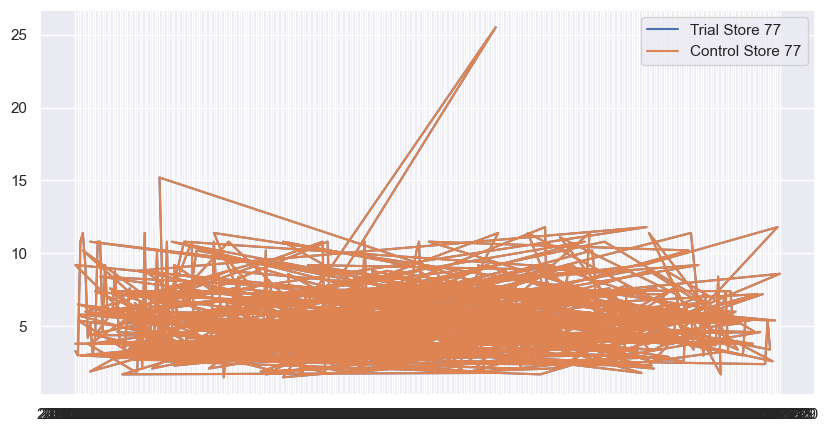

Trial store 86 vs Control store 11:
Correlation: 0.815725937451695


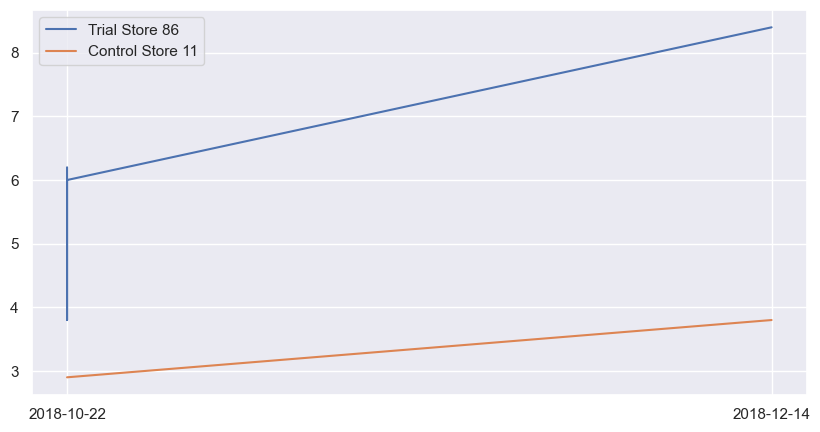

Trial store 88 vs Control store 88:
Correlation: 1.0


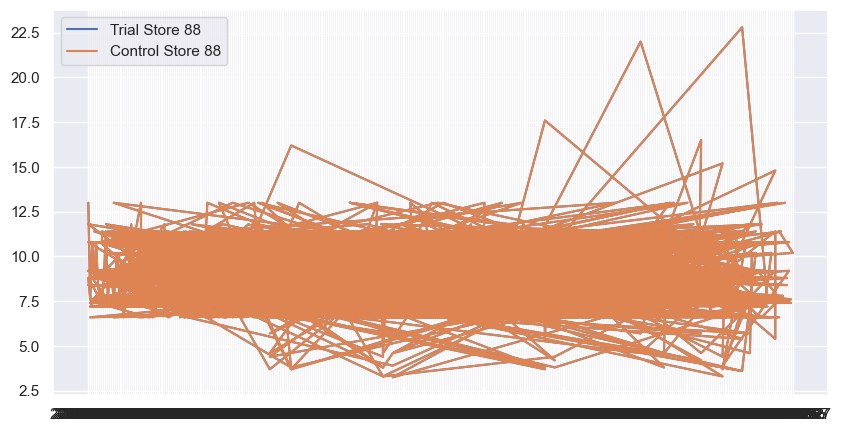

In [18]:
from scipy.stats import pearsonr

# Define a function to select control stores
def select_control_store(trial_store, metric):
    correlations = {}
    for store in data['STORE_NBR'].unique():
        control_store_data = data[data['STORE_NBR'] == store][metric]
        trial_store_data = data[data['STORE_NBR'] == trial_store][metric]

        # Make sure the lengths match
        min_length = min(len(control_store_data), len(trial_store_data))

        control_store_data = control_store_data[:min_length]
        trial_store_data = trial_store_data[:min_length]

        correlation = pearsonr(control_store_data, trial_store_data)[0]
        correlations[store] = correlation

    # Select the store with the highest correlation
    control_store = max(correlations, key=correlations.get)
    return control_store

# Use the function to select a control store for each trial store
control_stores = [select_control_store(trial_store, 'TOT_SALES') for trial_store in [77, 86, 88]]

# Set the date as the index of your DataFrame
data = data.set_index('DATE')

# Compare the trial and control stores
for trial_store, control_store in zip([77, 86, 88], control_stores):
    trial_store_data = data[data['STORE_NBR'] == trial_store]['TOT_SALES']
    control_store_data = data[data['STORE_NBR'] == control_store]['TOT_SALES']
    
    # Align the two series on their index
    trial_store_data, control_store_data = trial_store_data.align(control_store_data, join='inner')

    print(f'Trial store {trial_store} vs Control store {control_store}:')
    print(f'Correlation: {pearsonr(trial_store_data, control_store_data)[0]}')

    # Visualize the results
    plt.figure(figsize=(10, 5))
    plt.plot(trial_store_data, label=f'Trial Store {trial_store}')
    plt.plot(control_store_data, label=f'Control Store {control_store}')
    plt.legend()
    plt.show()

# Summarize the findings
# This will be specific to your data and the results of the analysis